## Import & Utility

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
import re
import math
import random

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score,roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

def draw_gini(actual, predictions):
    data = zip(actual, predictions)
    sorted_data = sorted(data, key=lambda d: d[1])
    sorted_actual = [d[0] for d in sorted_data]
    #print('Sorted Actual Values', sorted_actual)
    cumulative_actual = np.cumsum(sorted_actual)
    cumulative_index = np.arange(1, len(cumulative_actual)+1)

    cumulative_actual_shares = cumulative_actual / sum(actual)
    cumulative_index_shares = cumulative_index / len(predictions)
    
    # Add (0, 0) to the plot
    x_values = [0] + list(cumulative_index_shares)
    y_values = [0] + list(cumulative_actual_shares)

    # Display the 45° line stacked on top of the y values
    diagonal = [x - y for (x, y) in zip(x_values, y_values)]

    plt.stackplot(x_values, y_values, diagonal)
    plt.xlabel('Cumulative Share of Predictions')
    plt.ylabel('Cumulative Share of Actual Values')
    #plt.show()

def output_acc(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print(confusion_matrix(y_test, y_pred))
    
def output_gini(y_test, y_pred):
    gini_predictions = gini(y_test, y_pred)
    gini_max = gini(y_test, y_test)
    ngini= gini_normalized(y_test, y_pred)
    print('Gini: %.6f, Max. Gini: %.6f, Normalized Gini: %.6f' % (gini_predictions, gini_max, ngini))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print('AUC is : %.6f' % auc(fpr, tpr))
    #plt.plot(fpr, tpr, 'b')
    #plt.show()
    
    draw_gini(y_test,y_pred)

## Data Preparation

In [2]:
training_dataset = pd.read_csv('./data_processing/training_data.csv').iloc[:,1:]
testing_dataset = pd.read_csv('./data_processing/testing_data.csv').iloc[:,1:]

def get_XYT(col_list=None):
    if col_list is not None:
        training_subset = training_dataset[col_list+['Label']]
        testing_subset = testing_dataset[col_list]
    else:
        training_subset = training_dataset
        testing_subset = testing_dataset
        
    X_v = training_subset.iloc[:, :-1].values
    y_v = training_subset.iloc[:, -1].values
    y_v = np.asarray(y_v, int)
    T_v = testing_subset.iloc[:,].values
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_v, y_v, test_size=0.3, random_state=1)

    std_scaler = StandardScaler()
    sc = MinMaxScaler()
    rb = RobustScaler()

    Xtrain=sc.fit_transform(Xtrain)
    Xtest=sc.transform(Xtest)
    T_v=sc.transform(T_v)
    return Xtrain, Xtest, ytrain, ytest, T_v

Xtrain, Xtest, ytrain, ytest, T = get_XYT()


## Model Tuning & Feature Selection

In [5]:
classifiers = {
    "LogisiticRegression": LogisticRegression(penalty='l2'),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "Grad Booster": GradientBoostingClassifier(),
     "X Grad Booster": XGBClassifier(),
    "extra tree":ExtraTreesClassifier(),
    "Random forest":RandomForestClassifier()
}



for key, classifier in classifiers.items():
    classifier.fit(Xtrain, ytrain)
    training_score = cross_val_score(classifier, Xtrain, ytrain, cv=5, scoring='roc_auc')
    print(training_score)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 6) * 100, "% auc score")
    #training_score = cross_val_score(classifier, Xtrain, ytrain, cv=5, scoring='accuracy')
    #print(training_score)
    #print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 6) * 100, "% accuracy_score")

[0.90054237 0.91247768 0.91045206 0.90165264 0.90436808]
Classifiers:  LogisticRegression Has a training score of 90.5899 % auc score
[0.91198709 0.91085259 0.91774657 0.90840247 0.91049875]
Classifiers:  KNeighborsClassifier Has a training score of 91.1897 % auc score
[0.89499464 0.90801469 0.90512016 0.89824481 0.89986479]
Classifiers:  SVC Has a training score of 90.12480000000001 % auc score
[0.84282361 0.85033165 0.84570641 0.83685647 0.84144599]
Classifiers:  DecisionTreeClassifier Has a training score of 84.3433 % auc score
[0.94959309 0.95215598 0.95297668 0.9481772  0.95419945]
Classifiers:  GradientBoostingClassifier Has a training score of 95.14200000000001 % auc score
[0.95608067 0.9620575  0.96124828 0.95511837 0.95868054]
Classifiers:  XGBClassifier Has a training score of 95.8637 % auc score
[0.93795984 0.94901985 0.94321573 0.93702561 0.943666  ]
Classifiers:  ExtraTreesClassifier Has a training score of 94.21770000000001 % auc score
[0.93824557 0.94522042 0.94471146 0.

In [8]:
check_rfe= True
if check_rfe:
    rfes = []
    scores = []
    for n in range(max(6, len(training_dataset.columns)-10),len(training_dataset.columns)):
        xgb = XGBClassifier(n_estimators=500, learning_rate=0.2,max_depth=6, min_child_weight=1)
        rfe = RFE(LogisticRegression(penalty='l1'), n, 1).fit(Xtrain, ytrain)
        rfes.append(rfe)
        yHat = rfe.predict(Xtrain)
        scores.append(roc_auc_score(ytrain, yHat))
    best_rfe = rfes[scores.index(max(scores))]
    results = best_rfe.support_ # what features where used
    new_cols = [] # X with selected features
    for feat, result in list(zip(training_dataset.columns[:-1], results)):
        if result == True:
            new_cols.append(feat)

    print(f'The features with optimal result is {new_cols}')

    Xtrain, Xtest, ytrain, ytest, T = get_XYT(new_cols)

The features with optimal result is ['source_pre_siz', 'sink_pre_siz', 'source_suc_siz', 'pre_pre_cos', 'suc_pre_cos', 'uhi', 'Common_Following_With_Sink_Followers', 'Common_follower_with_source_followings', 'Jaccard_coefficient', 'Within_inter_cluster']


In [5]:
training_dataset.columns

Index(['source_pre_siz', 'sink_pre_siz', 'source_suc_siz', 'sink_suc_siz',
       'pre_pre_cos', 'suc_pre_cos', 'uhi', 'Common_Following',
       'Common_Follower', 'Common_Following_With_Sink_Followers',
       'Common_follower_with_source_followings', 'Resource_allocation_index',
       'Jaccard_coefficient', 'Adamic_adar_index', 'Cn_soundarajan_hopcroft',
       'Ra_index_soundarajan_hopcroft', 'Within_inter_cluster',
       'Preferential_attachment', 'Label'],
      dtype='object')

In [6]:
parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.2, 0.05, 0.02], #so called `eta` value
              'max_depth': [3, 6],
              'min_child_weight': [10, 50],
              'subsample': [0.8],
              'n_estimators': [100, 500], #number of trees, change it to 1000 for better results
              'seed': [1337]}

kfold = StratifiedKFold(n_splits=3)
clf = GridSearchCV(XGBClassifier(), parameters, n_jobs=5, 
                   cv=kfold, 
                   scoring='roc_auc',
                   verbose=2, refit=True)
clf.fit(Xtrain, ytrain)

XGB_best = clf.best_estimator_

# Best score
print(clf.best_score_)
print(XGB_best.get_params())

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done  72 out of  72 | elapsed:  2.8min finished


0.9635503988113336
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 10, 'missing': None, 'n_estimators': 500, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 1337, 'silent': True, 'subsample': 0.8}


Gini: 0.229970, Max. Gini: 0.245833, Normalized Gini: 0.935472
AUC is : 0.967736
Accuracy: 89.82%
[[2699  251]
 [ 360 2690]]


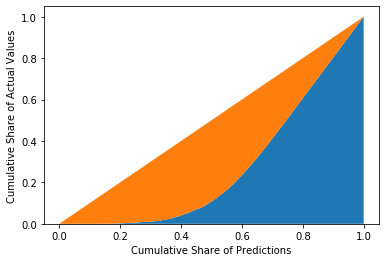

In [7]:
XGB_best.fit(Xtrain, ytrain)
ypred = XGB_best.predict_proba(Xtest)[:,1]
output_gini(ytest, ypred)
ypred = XGB_best.predict(Xtest)
output_acc(ytest, ypred)

Gini: 0.202785, Max. Gini: 0.245833, Normalized Gini: 0.824888
AUC is : 0.912444
Accuracy: 81.78%
[[2568  382]
 [ 711 2339]]


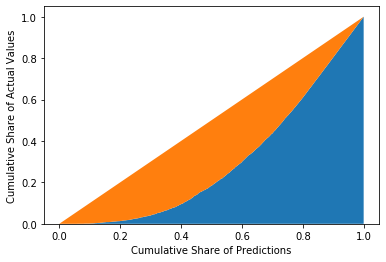

In [8]:
#Simple LR model
lr = LogisticRegression(penalty='l1')
lr.fit(Xtrain, ytrain)
ypred = lr.predict_proba(Xtest)[:,1]
output_gini(ytest, ypred)

ypred = lr.predict(Xtest)
output_acc(ytest, ypred)

Gini: 0.198159, Max. Gini: 0.245833, Normalized Gini: 0.806070
AUC is : 0.903034
Accuracy: 80.48%
[[2541  409]
 [ 762 2288]]


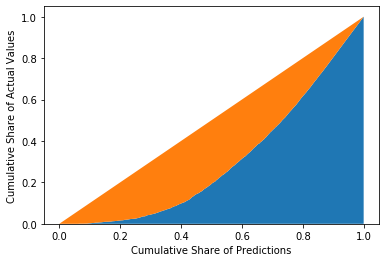

In [9]:
#Classic SVM model
svm = SVC(probability=True)
svm.fit(Xtrain, ytrain)
ypred = svm.predict_proba(Xtest)[:,1]
output_gini(ytest, ypred)

ypred = svm.predict(Xtest)
output_acc(ytest, ypred)

## Submission

In [10]:
tpred=XGB_best.predict_proba(T)[:,1]
x=pd.DataFrame({'Id':np.arange(1,2001), 'Predicted':tpred})
x.to_csv('./data_processing/submit.csv',index=False)